# Lesson 5

## Purpose

The goal of this Lesson is to look at more advanced features of the matching software

* Multiple experiments
* Multiple score
* Scores that apply to only a subset of the data
* Fractionation
* Multiple components
* Per-component parameters

## Standard imports

In [1]:
#from IPython.core.display import display, HTML
from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

#Python path library support
from pathlib import Path

#python numeric library
import numpy

#python math library
import math

#scientific library for python
import scipy

#pandas is python library for data analysis
import pandas

#addict is a library that makes it easier to create nested dictionaries
from addict import Dict

#json is a standard text based format and it used in CADETMatch for the configuration file
import json

#python plotting library
import matplotlib.pyplot as plt

#cadet python interface
from cadet import Cadet

#jupyter widget support
from ipywidgets import interact
import ipywidgets as widgets

from CADETMatch.jupyter import Match

#This is just a support function to make running the examples a bit easier later
def deleteResultDir(path):
    #This is to try and make sure that only an actual result directory can be removed
    #And only if no other files have been added to the directory, just in case
    if not path.exists():
        return
    allowed = {'evo', 'grad', 'log', 'mcmc', 'meta', 'misc', 'progress', 
               'space', 'error.csv', 'result.h5', 'progress.csv'}
    allowed.add(match.csv)
    allowed.add(match_file.name)
    okayToRemove = False
    for child in path.iterdir():
        if child.name not in allowed:
            break
    else:
        okayToRemove = True
    if okayToRemove:
        import shutil
        shutil.rmtree(path)
        
def fractionate(start_seq, stop_seq, times, values):
    temp = []
    for (start, stop) in zip(start_seq, stop_seq):
        selected = (times >= start) & (times <= stop)
        local_times = times[selected]
        local_values = values[selected]
        
        stop = local_times[-1]
        start = local_times[0]

        temp.append(numpy.trapz(local_values, local_times)/ (stop - start))
    return numpy.array(temp)

def run_match(match_obj, match_file, true_values, delete):
    "create the matching object, run it and then look at output"
    match = Match(match_file.as_posix())

    resultDir = Path(match_obj.baseDir) / match_obj.resultsDir
    print("Your results are located at", resultDir.as_posix(), '\n\n')

    #If you want to delete the fitting process to start over remove the # from the next line and re-run this cell\
    if delete:
        deleteResultDir(resultDir)

    match.start_sim()

    match.plot_best()
    best ,score, best_score = match.get_best()
    for key,value in best_score.items():
        print("Method: %s" % key)
        for name, val, true_value in zip(match.cache.parameter_headers, value, true_values):
            print("%s = %.2e  true_value = %.2e error: %.2g%%" % (name, val, true_value, numpy.abs(val-true_value)/val*100))
        print('\n')
    return match

## Setup CADET path

In order to run examples we need to specify where CADET is.

On Windows just change the cadet_bin_path to the bin directory of CADET

On Linux you need to change the cadet_bin_path and also change cadet-cli.exe to cadet-cli on the following line.

In [2]:
#put in the path to the bin folder
cadet_bin_path = Path(r"C:\Users\kosh_000\cadet_build\CADET\VCPKG\bin")

cadet_path = cadet_bin_path / "cadet-cli.exe"

if cadet_path.exists():
    print("CADET was found. Continue to the next step.")
    Cadet.cadet_path = cadet_path.as_posix()
else:
    print('CADET could not be found. Please check the bin path')
    
print(cadet_path.as_posix())

CADET was found. Continue to the next step.
C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe


## Create lesson folders and create lesson variables

This will create all the lesson folders we need and make it easier to refer to previous lessons

In [3]:
#set this to a directory on your computer where the cadet tutorial files can be saved
cadet_tutorial = Path('F:/temp/cadet_tutorial')
lesson_1 = cadet_tutorial / "lesson_1"
lesson_2 = cadet_tutorial / "lesson_2"
lesson_3 = cadet_tutorial / "lesson_3"
lesson_4 = cadet_tutorial / "lesson_4"
lesson_5 = cadet_tutorial / "lesson_5"
lesson_5.mkdir(exist_ok = True, parents=True)

# Scoring on part of a chromatogram
Sometimes there is noise in your system or some other peak in your system that you know the cause of but you don't want the matching system to look at. You could even have a high molecular weight species that you don't want to model. For these cases you can apply the score to just a section of the chromatogram.

I am making a copy of our existing dextran example from Lesson 1 and then adding a small peak to it before the main peak and then we will look at how the fitting works.

CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_5/slice/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


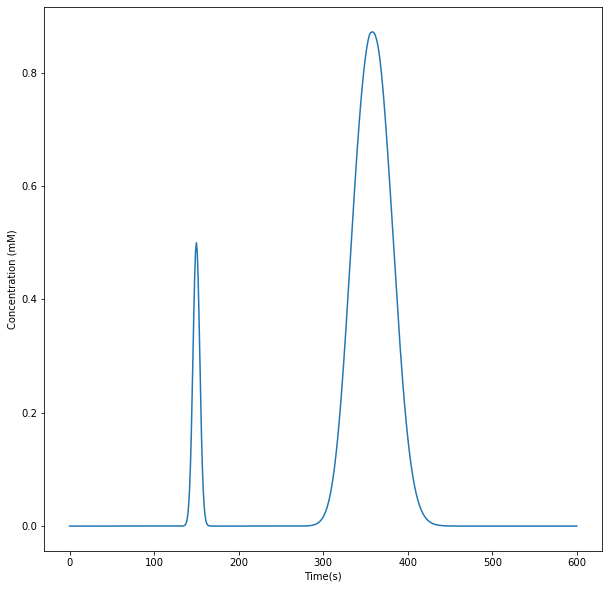

In [4]:
slice_dir = lesson_5 / "slice"
slice_dir.mkdir(exist_ok = True)

simple = Cadet()

#give a filename for where the simulation should be saved
simple.filename = (lesson_1 / "simple_example" / 'example.h5').as_posix()

simple.load()

simple.filename = (slice_dir / 'example.h5').as_posix()

#save the simulation
simple.save()

#run the simulation
data = simple.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    simple.load()
    
    times = simple.root.output.solution.solution_times
    values = simple.root.output.solution.unit_002.solution_outlet_comp_000
    
    #add a small peak to values between 100 and 200 seconds
    
    selected = (times >= 100) & (times <= 200)
    values[selected] = scipy.signal.gaussian(101, 4) * 0.5
    
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(times,
        values)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([times,
                        values]).transpose()
    data.to_csv((slice_dir / 'example.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Look at the simple match
We will first use the example from Lesson 4 to match this data set without any slicing and see what happens

In [5]:
match = Dict()
match.CADETPath = cadet_path.as_posix()
match.baseDir = slice_dir.as_posix()
match.resultsDir = 'fit_nsga3'
match.csv = 'fit_results.csv'
match.checkpointFile = "check"
match.stopAverage = 1
match.stopBest = 1
match.gradCheck = 1
match.gradVector = 1
match.searchMethod = 'NSGA3'
match.mutationRate = 1.0
match.crossoverRate = 1.0
match.generations = 1000
match.population = 12
match.minPopulation = 12
match.maxPopulation = 12
match.finalGradRefinement = 1
match.stallGenerations = 10

parameter1 = Dict()
parameter1.transform = 'norm_log'
parameter1.component = -1
parameter1.bound = -1
parameter1.location = "/input/model/unit_001/COL_DISPERSION"
parameter1.min = 1e-10
parameter1.max = 1e-6

parameter2 = Dict()
parameter2.transform = 'norm'
parameter2.component = -1
parameter2.bound = -1
parameter2.location = "/input/model/unit_001/COL_POROSITY"
parameter2.min = 0.2
parameter2.max = 0.5

match.parameters = [parameter1, parameter2]

experiment1 = Dict()
experiment1.csv = "example.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"
experiment1.timeout = 30.0

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'DextranShape'

experiment1.features = [feature1,]

match.experiments = [experiment1,]

match_file = slice_dir / 'example_nsga3_simple.json'

with (match_file).open('w') as json_file:
    json.dump(match.to_dict(), json_file, indent='\t')

## Run parameter estimation on the full chromatogram

Your results are located at F:/temp/cadet_tutorial/lesson_5/slice/fit_nsga3 


[2019-10-10 16:37:43,277] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-10 16:37:43,278] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-10 16:37:43,278] launcher  INFO    Worker distribution: 

[2019-10-10 16:37:43,278] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-10 16:37:46,134] util      (b'127.0.0.1:50701') INFO    example.h5 abstol=3.03e-05  reltol=0.0001

[2019-10-10 16:37:46,279] match     (b'127.0.0.1:50701') INFO    simulation took 0.14499974250793457

[2019-10-10 16:37:46,669] gradFD    (b'127.0.0.1:50701') INFO    grad simulation took 0.36020946502685547

[2019-10-10 16:37:46,669] gradFD    (b'127.0.0.1:50701') INFO    grad F:/temp/cadet_tutorial/lesson_5/slice/fit_nsga3/misc/template_main_grad.h5 abstol=3.03e-11  reltol=1e-10

[2019-10-10 16:37:4

[2019-10-10 16:46:58,503] generate_corner_graphs (b'127.0.0.1:54291') INFO    graphing directory F:\temp\cadet_tutorial\lesson_5\slice

[2019-10-10 16:46:58,504] generate_corner_graphs (b'127.0.0.1:54291') INFO    plotting corner plots

[2019-10-10 16:46:58,509] generate_corner_graphs (b'127.0.0.1:54291') INFO    graphing remove 0 points

[2019-10-10 16:47:12,920] launcher  (127.0.0.1:61416) INFO    Root process is done.

[2019-10-10 16:47:12,921] launcher  (127.0.0.1:61416) INFO    Finished cleaning spawned subprocesses.

[2019-10-10 16:47:12,934] match     (b'127.0.0.1:50701') INFO    altFeatures False

[2019-10-10 16:47:12,934] match     (b'127.0.0.1:50701') INFO    altFeatureNames []

[2019-10-10 16:47:12,934] match     (b'127.0.0.1:50701') INFO    System has finished

[2019-10-10 16:47:12,934] match     (b'127.0.0.1:50701') INFO    The total runtime was 566.9481906890869 seconds

[2019-10-10 16:47:13,730] launcher  (127.0.0.1:61010) INFO    Root process is done.

[2019-10-10 16:47

,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_Shape,main_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
75,Thu Oct 10 16:40:49 2019,f3e693a12d704c320fa46f620b3586c4,GRAD,NaN,4.279954e-08,0.200116,0.99928,0.929529,0.963773,0.929529,0.964404,0.38099


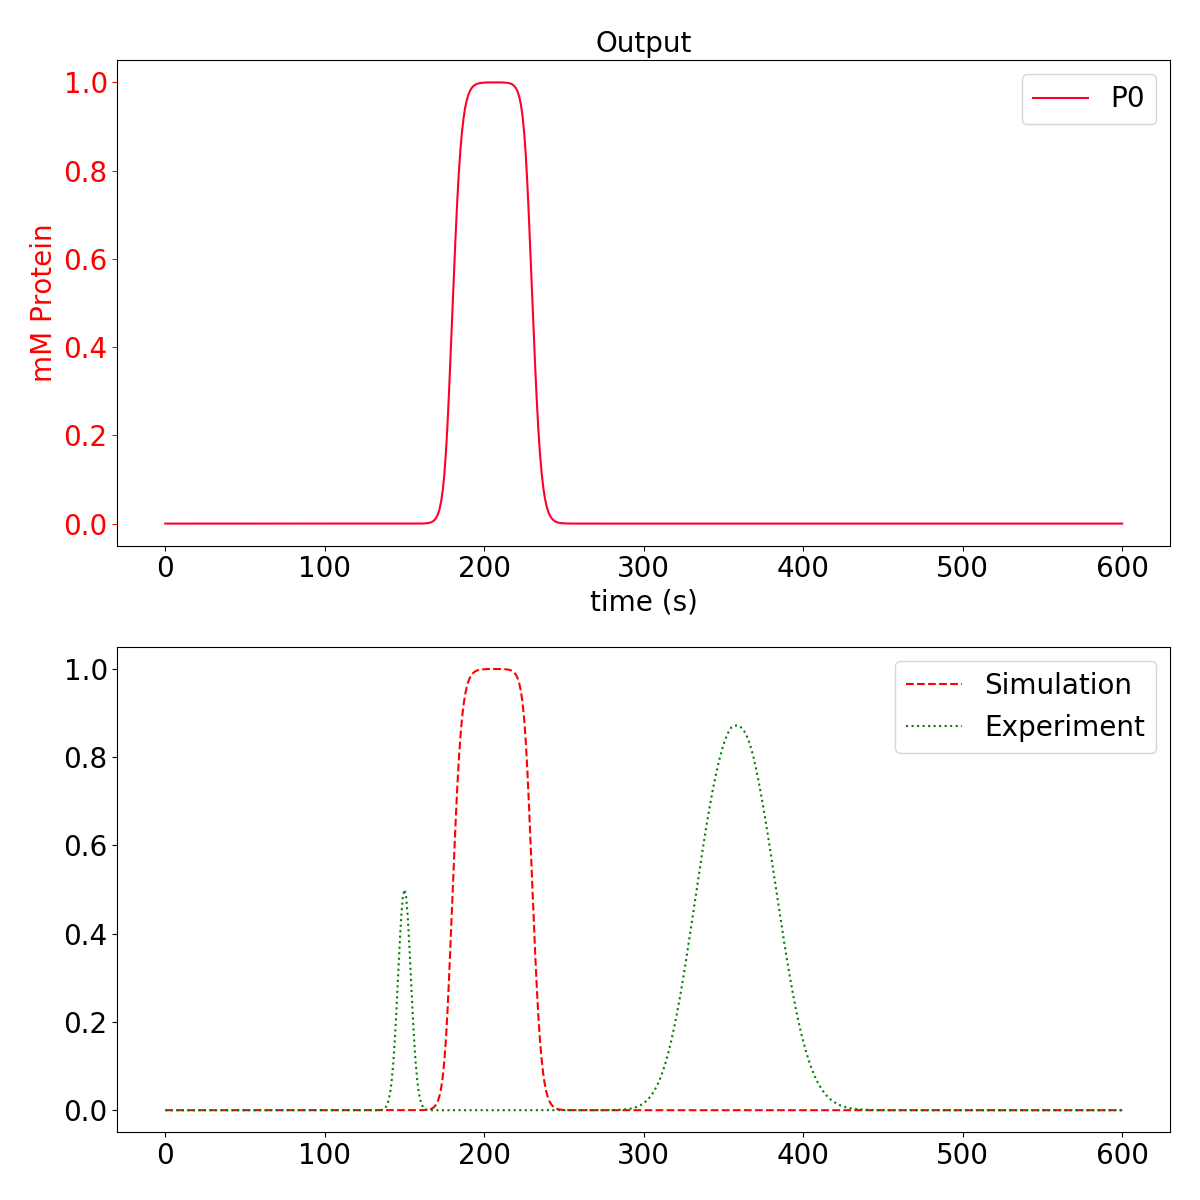

,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_Shape,main_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
55,Thu Oct 10 16:38:12 2019,24f39f25be7fcda34a2f5be2cadd45f3,EVO,NaN,6.674547e-07,0.20001,0.936792,0.936579,0.936686,0.936579,0.936686,0.685826


Best item 24f39f25be7fcda34a2f5be2cadd45f3 for meta score(s) Min Score , SSE


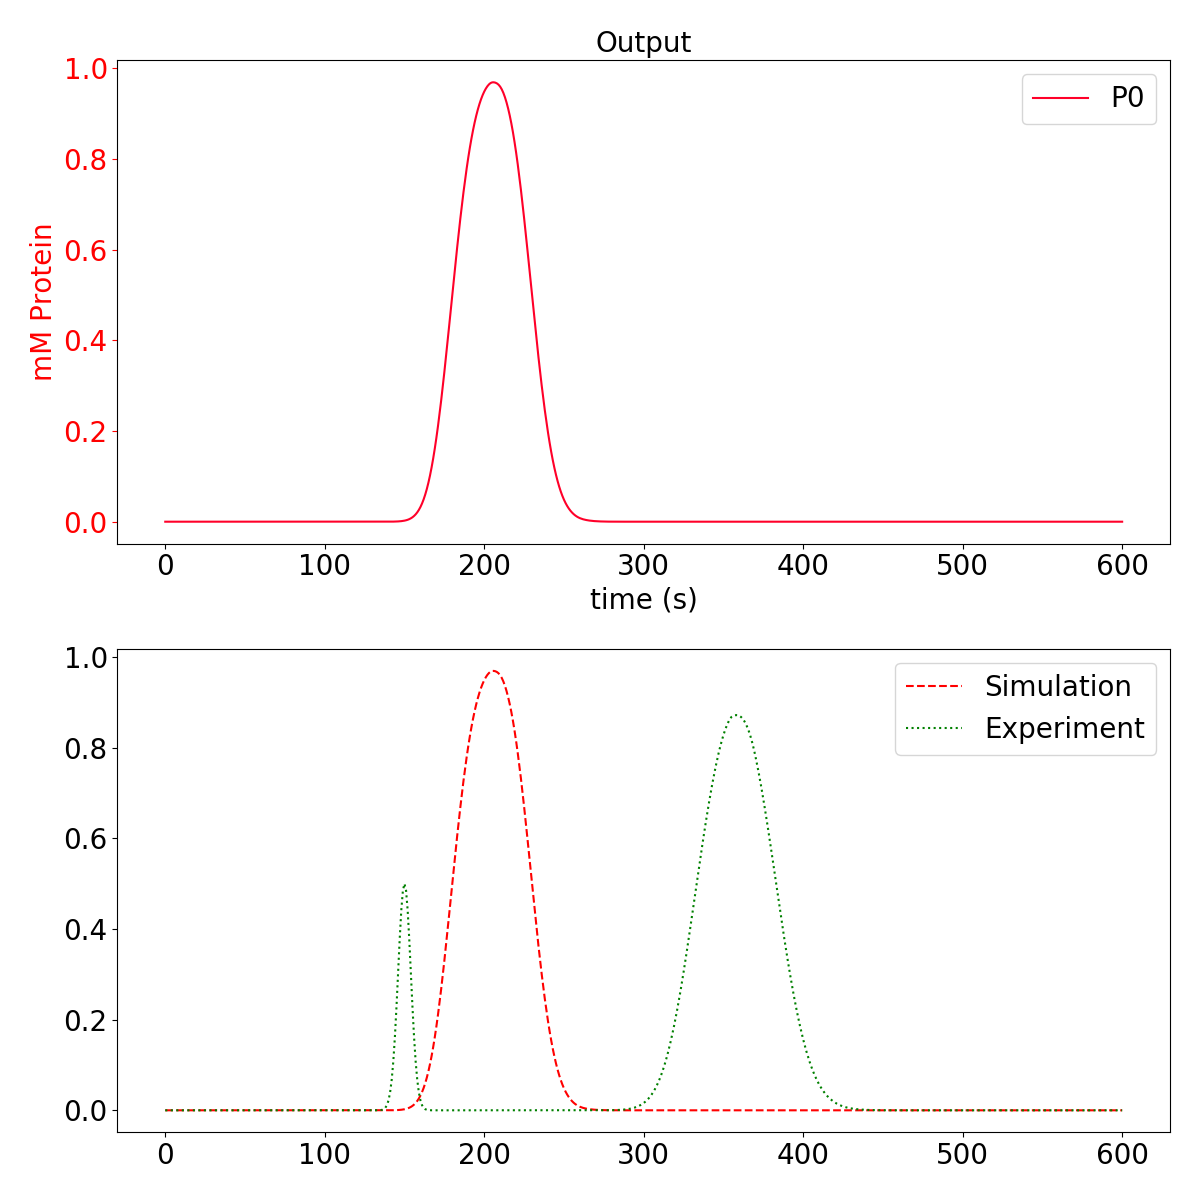

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 4.28e-08  true_value = 2.00e-07 error: 3.7e+02%
COL_POROSITY Comp:-1 Bound:-1 = 2.00e-01  true_value = 3.70e-01 error: 85%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 6.67e-07  true_value = 2.00e-07 error: 70%
COL_POROSITY Comp:-1 Bound:-1 = 2.00e-01  true_value = 3.70e-01 error: 85%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 4.28e-08  true_value = 2.00e-07 error: 3.7e+02%
COL_POROSITY Comp:-1 Bound:-1 = 2.00e-01  true_value = 3.70e-01 error: 85%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 6.67e-07  true_value = 2.00e-07 error: 70%
COL_POROSITY Comp:-1 Bound:-1 = 2.00e-01  true_value = 3.70e-01 error: 85%




In [6]:
true_values = numpy.array([simple.root.input.model.unit_001.col_dispersion, 
                           simple.root.input.model.unit_001.col_porosity])
    
sim_simple = run_match(match,
                    match_file,
                    true_values,
                    delete=True)

## Create a configuration file for a slice

Features inside experiments take an optional start and stop argument. If you provide start and stop the score will only apply inside that region.

```json
{
  "name": "Pulse",
  "type": "DextranShape"
}```

```python
feature = Dict()
feature.name = "Pulse"
feature.type = "DextranShape"``` 

Gets changed to

```json
{
  "name": "Pulse",
  "type": "DextranShape"
  "start": 250,
  "stop": 450
}```

```python
feature = Dict()
feature.name = "Pulse"
feature.type = "DextranShape"
feature.start = 250
feature.stop = 450``` 

In [7]:
match_slice = Dict(match.copy())
match_slice.CADETPath = cadet_path.as_posix()
match_slice.baseDir = slice_dir.as_posix()
match_slice.resultsDir = 'fit_nsga3_slice'


experiment1 = Dict()
experiment1.csv = "example.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"
experiment1.timeout = 30.0

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'DextranShape'
feature1.start = 250
feature1.stop = 450

experiment1.features = [feature1,]

match_slice.experiments = [experiment1,]

match_file = slice_dir / 'example_nsga3_slice.json'

with (match_file).open('w') as json_file:
    json.dump(match_slice.to_dict(), json_file, indent='\t')

## Run parameter estimation on a slice

Your results are located at F:/temp/cadet_tutorial/lesson_5/slice/fit_nsga3_slice 


[2019-10-02 10:28:13,841] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-02 10:28:13,841] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-02 10:28:13,841] launcher  INFO    Worker distribution: 

[2019-10-02 10:28:13,841] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-02 10:28:19,178] util      (b'127.0.0.1:51645') INFO    Generation: -1 	Population: 24 	Average Score: 0.874 	Best: 0.955 	Minimum Score: 0.755 	Best: 0.922 	Product Score: 0.855 	Best: 0.954

[2019-10-02 10:28:20,044] util      (b'127.0.0.1:51645') INFO    Generation: 0 	Population: 24 	Average Score: 0.893 	Best: 0.972 	Minimum Score: 0.795 	Best: 0.957 	Product Score: 0.879 	Best: 0.972

[2019-10-02 10:28:20,908] util      (b'127.0.0.1:51645') INFO    Generation: 1 	Population: 24 	Average

[2019-10-02 10:28:52,073] util      (b'127.0.0.1:51645') INFO    Generation: 39 	Population: 24 	Average Score: 0.996 	Best: 1 	Minimum Score: 0.993 	Best: 1 	Product Score: 0.996 	Best: 1

[2019-10-02 10:28:52,826] util      (b'127.0.0.1:51645') INFO    Generation: 40 	Population: 24 	Average Score: 0.996 	Best: 1 	Minimum Score: 0.993 	Best: 1 	Product Score: 0.996 	Best: 1

[2019-10-02 10:28:53,669] util      (b'127.0.0.1:51645') INFO    Generation: 41 	Population: 24 	Average Score: 0.997 	Best: 1 	Minimum Score: 0.993 	Best: 1 	Product Score: 0.996 	Best: 1

[2019-10-02 10:28:54,434] util      (b'127.0.0.1:51645') INFO    Generation: 42 	Population: 24 	Average Score: 0.997 	Best: 1 	Minimum Score: 0.993 	Best: 1 	Product Score: 0.996 	Best: 1

[2019-10-02 10:28:55,149] util      (b'127.0.0.1:51645') INFO    Generation: 43 	Population: 24 	Average Score: 0.997 	Best: 1 	Minimum Score: 0.993 	Best: 1 	Product Score: 0.996 	Best: 1

[2019-10-02 10:28:55,888] util      (b'127.0.0.1:5

,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_Shape,main_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
0,Wed Oct 2 10:29:01 2019,e048497758ff26f2c34a4249ac6d6f14,GRAD,NaN,1.999995e-07,0.37,1.0,1.0,1.0,1.0,1.0,2.286652e-15


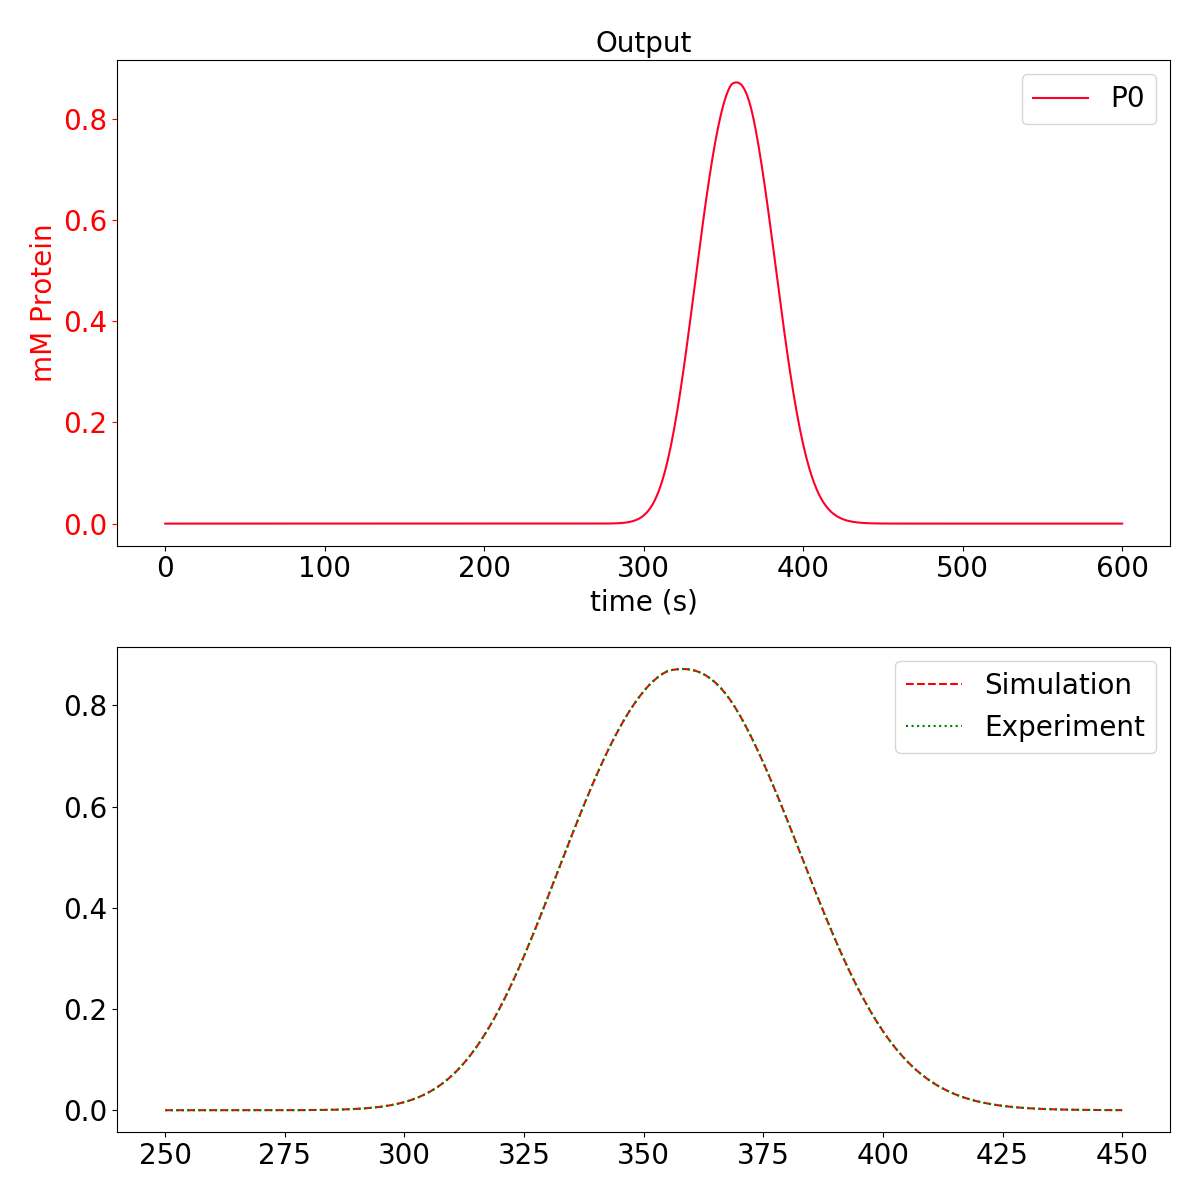

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 0.00027%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 1.1e-05%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 0.00027%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 1.1e-05%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 0.00027%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 1.1e-05%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 0.00027%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 1.1e-05%




In [8]:
true_values = numpy.array([simple.root.input.model.unit_001.col_dispersion, 
                           simple.root.input.model.unit_001.col_porosity])
    
sim_slice = run_match(match_slice,
                    match_file,
                    true_values,
                    delete=True)

# Multiple experiments
As the model becomes more complex it can require multiple experiments in order to obtain a unique answer. For fitting the Steric-Mass-Action isotherm usually 2-3 gradients + breakthrough is necessary. Multiple experiments are also useful when you have errors in your system

In this case we will create another variant of the Dextran pulse for fitting. For the purposes of the workshop we will just change the length of the column.

CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_5/multiple_experiments/example_1.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully
CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_5/multiple_experiments/example_2.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


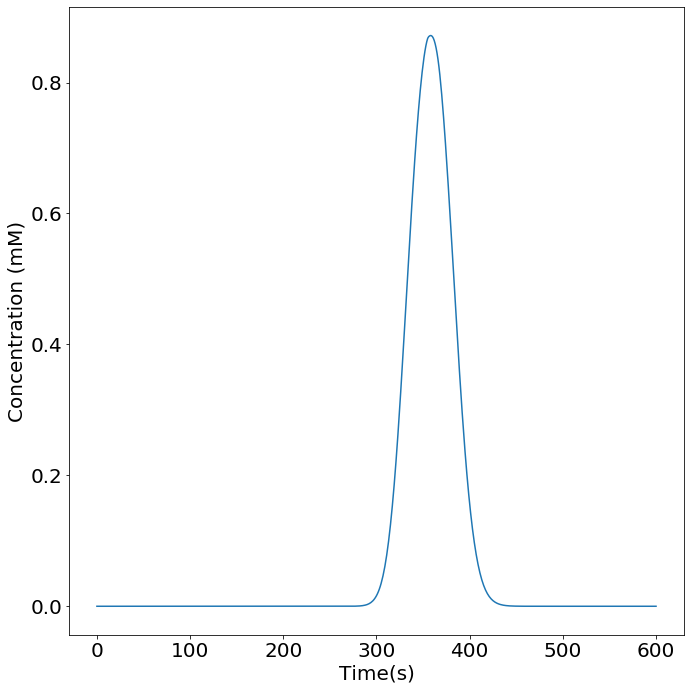

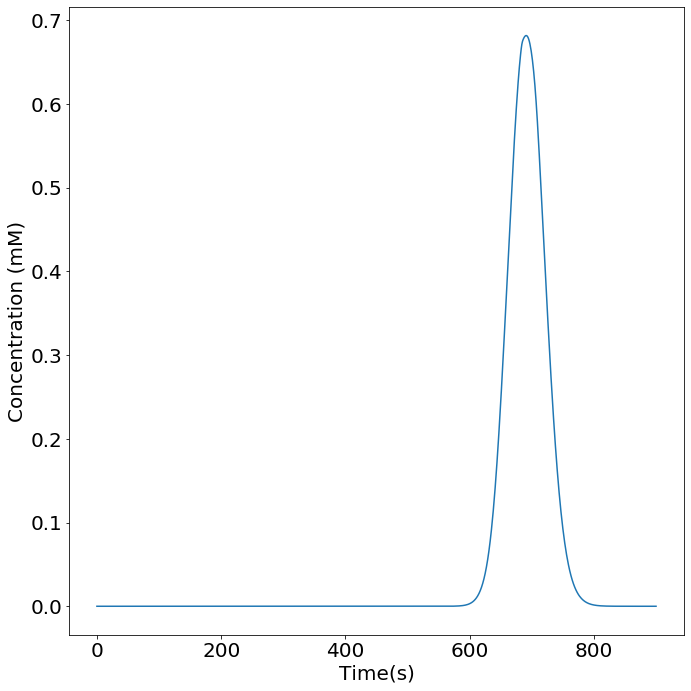

In [22]:
multiple_dir = lesson_5 / "multiple_experiments"
multiple_dir.mkdir(exist_ok = True)

simple = Cadet()

#give a filename for where the simulation should be saved
simple.filename = (lesson_1 / "simple_example" / 'example.h5').as_posix()

simple.load()

simple.filename = (multiple_dir / 'example_1.h5').as_posix()

#save the simulation
simple.save()

#run the simulation
data = simple.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    simple.load()
    
    times = simple.root.output.solution.solution_times
    values = simple.root.output.solution.unit_002.solution_outlet_comp_000
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(times,
        values)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([times,
                        values]).transpose()
    data.to_csv((multiple_dir / 'example_1.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")
    
    
    
simple = Cadet()

#give a filename for where the simulation should be saved
simple.filename = (lesson_1 / "simple_example" / 'example.h5').as_posix()

simple.load()

simple.filename = (multiple_dir / 'example_2.h5').as_posix()

simple.root.input.model.unit_001.col_length = simple.root.input.model.unit_001.col_length * 2
simple.root.input.solver.sections.section_times = [0.0, 50.0, 900.0]
simple.root.input.solver.user_solution_times = numpy.linspace(0, 900, 901)

#save the simulation
simple.save()

#run the simulation
data = simple.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    simple.load()
    
    times = simple.root.output.solution.solution_times
    values = simple.root.output.solution.unit_002.solution_outlet_comp_000
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(times,
        values)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([times,
                        values]).transpose()
    data.to_csv((multiple_dir / 'example_2.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Create a configuration file

We are estimating one set of parameters for two experiments. Most of the file stays exactly the same and we just have to add two experiments.

The only thing we need to do is add another experiment and we can use the same score for this new experiment as the first experiment.

In [10]:
match_multiple = Dict(match.copy())
match_multiple.CADETPath = cadet_path.as_posix()
match_multiple.baseDir = multiple_dir.as_posix()
match_multiple.resultsDir = 'fit_nsga3_multiple'


experiment1 = Dict()
experiment1.csv = "example_1.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example_1.h5"
experiment1.name = "exp1"
experiment1.timeout = 30.0

experiment2 = Dict()
experiment2.csv = "example_2.csv"
experiment2.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment2.HDF5 = "example_2.h5"
experiment2.name = "exp2"
experiment2.timeout = 30.0

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'DextranShape'

experiment1.features = [feature1,]

experiment2.features = [feature1,]

match_multiple.experiments = [experiment1, experiment2]

match_file = multiple_dir / 'example_nsga3_multiple.json'

with (match_file).open('w') as json_file:
    json.dump(match_multiple.to_dict(), json_file, indent='\t')

## Run parameter estimation
Now that we have our new experimental setup we can run the matching process.

Your results are located at F:/temp/cadet_tutorial/lesson_5/multiple_experiments/fit_nsga3_multiple 


[2019-10-02 10:29:27,746] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-02 10:29:27,746] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-02 10:29:27,747] launcher  INFO    Worker distribution: 

[2019-10-02 10:29:27,747] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-02 10:29:33,971] util      (b'127.0.0.1:51230') INFO    Generation: -1 	Population: 24 	Average Score: 0.913 	Best: 0.973 	Minimum Score: 0.822 	Best: 0.945 	Product Score: 0.909 	Best: 0.973

[2019-10-02 10:29:35,795] util      (b'127.0.0.1:51230') INFO    Generation: 0 	Population: 24 	Average Score: 0.937 	Best: 0.99 	Minimum Score: 0.869 	Best: 0.986 	Product Score: 0.933 	Best: 0.99

[2019-10-02 10:29:37,487] util      (b'127.0.0.1:51230') INFO    Generation: 1 	Populat

[2019-10-02 10:30:38,534] util      (b'127.0.0.1:51230') INFO    Generation: 39 	Population: 24 	Average Score: 0.998 	Best: 1 	Minimum Score: 0.995 	Best: 1 	Product Score: 0.998 	Best: 1

[2019-10-02 10:30:40,141] util      (b'127.0.0.1:51230') INFO    Generation: 40 	Population: 24 	Average Score: 0.998 	Best: 1 	Minimum Score: 0.995 	Best: 1 	Product Score: 0.998 	Best: 1

[2019-10-02 10:30:41,859] util      (b'127.0.0.1:51230') INFO    Generation: 41 	Population: 24 	Average Score: 0.998 	Best: 1 	Minimum Score: 0.995 	Best: 1 	Product Score: 0.998 	Best: 1

[2019-10-02 10:30:43,439] util      (b'127.0.0.1:51230') INFO    Generation: 42 	Population: 24 	Average Score: 0.998 	Best: 1 	Minimum Score: 0.995 	Best: 1 	Product Score: 0.998 	Best: 1

[2019-10-02 10:30:45,099] util      (b'127.0.0.1:51230') INFO    Generation: 43 	Population: 24 	Average Score: 0.998 	Best: 1 	Minimum Score: 0.996 	Best: 1 	Product Score: 0.998 	Best: 1

[2019-10-02 10:30:46,674] util      (b'127.0.0.1:5

,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,exp1_Pulse_Shape,exp1_Pulse_Time,exp2_Pulse_Shape,exp2_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
1,Wed Oct 2 10:31:36 2019,52a717fcbc4d473b608c030d905ad5d8,GRAD,NaN,1.980341e-07,0.36985,0.999999,0.999996,1.0,0.999999,0.999999,0.999996,0.999999,0.000005


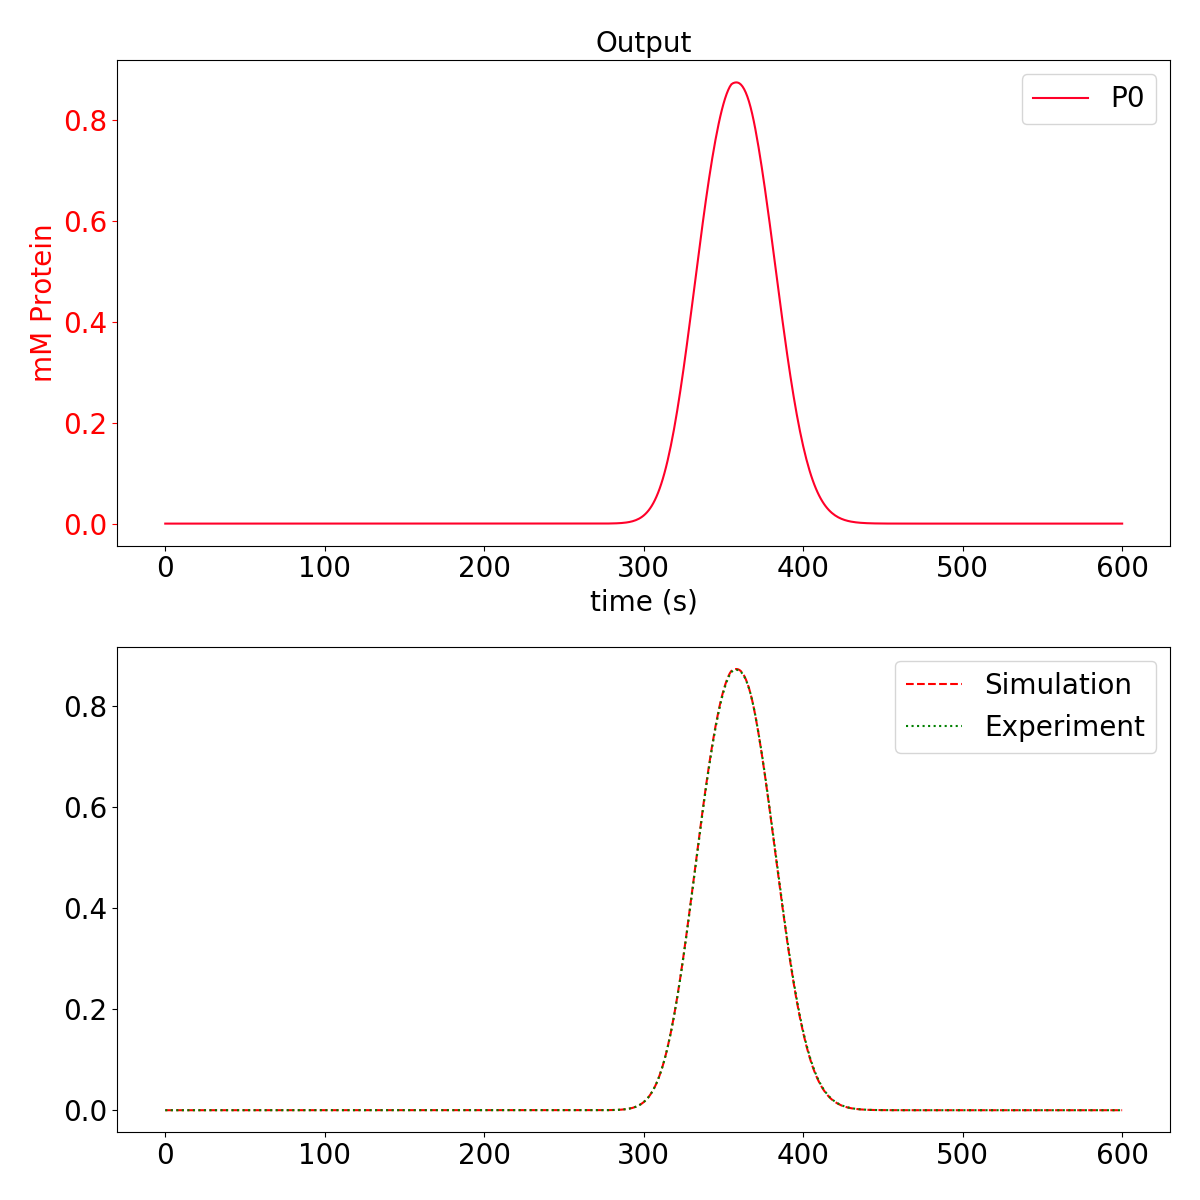

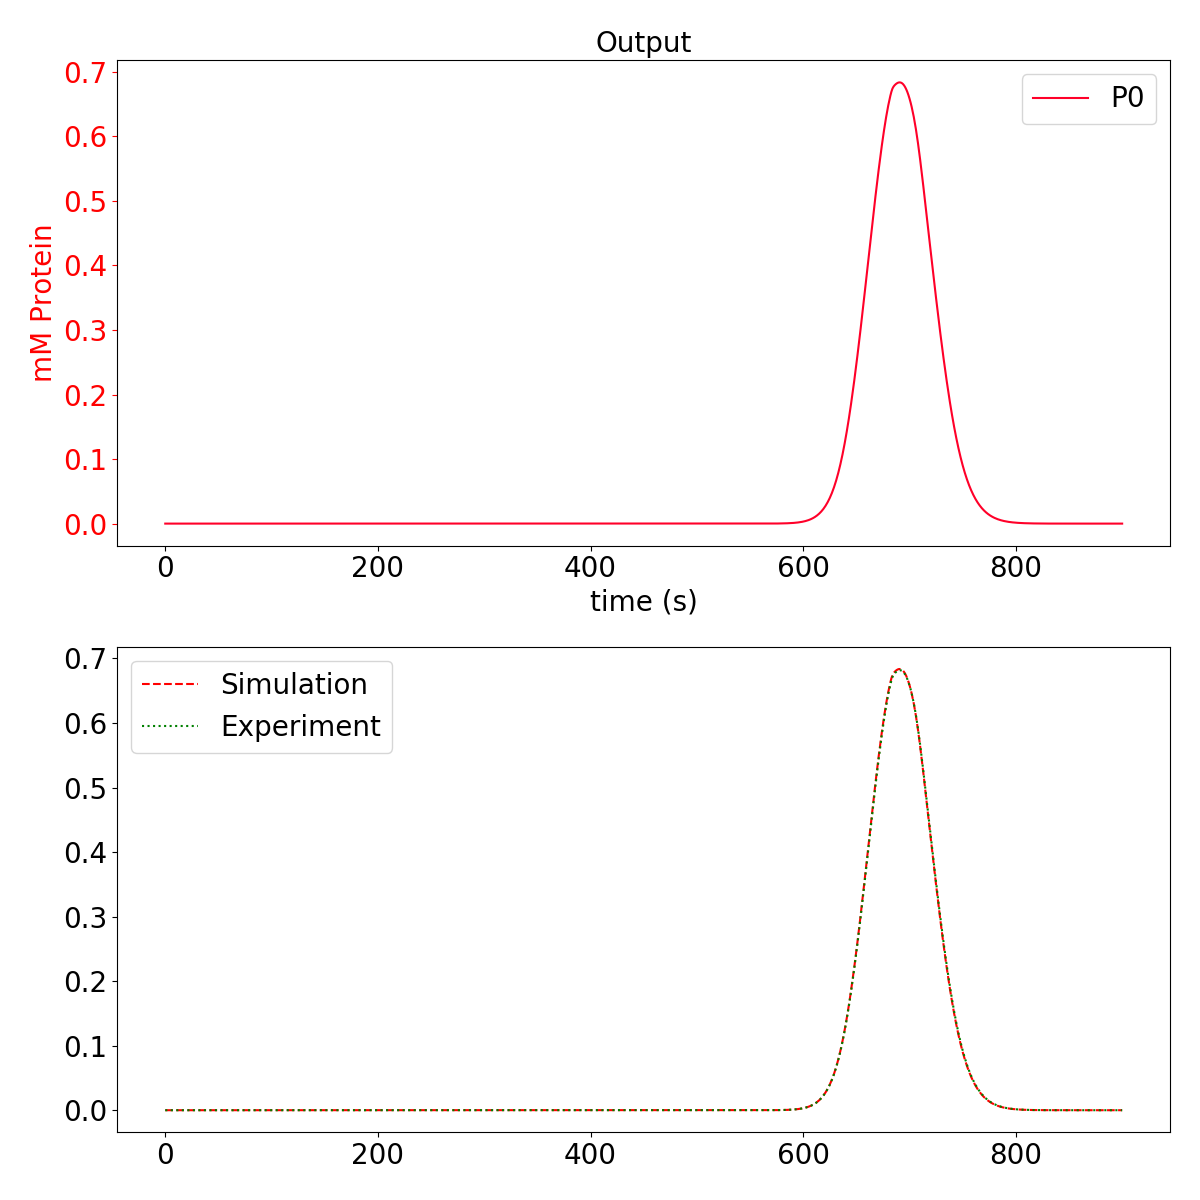

Best item 750899f047759c73ed27e497d3809d32 for meta score(s) Min Score , SSE


,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,exp1_Pulse_Shape,exp1_Pulse_Time,exp2_Pulse_Shape,exp2_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
0,Wed Oct 2 10:30:41 2019,750899f047759c73ed27e497d3809d32,EVO,NaN,1.997763e-07,0.36969,0.999999,0.999996,0.999999,0.999997,0.999998,0.999996,0.999998,0.000104


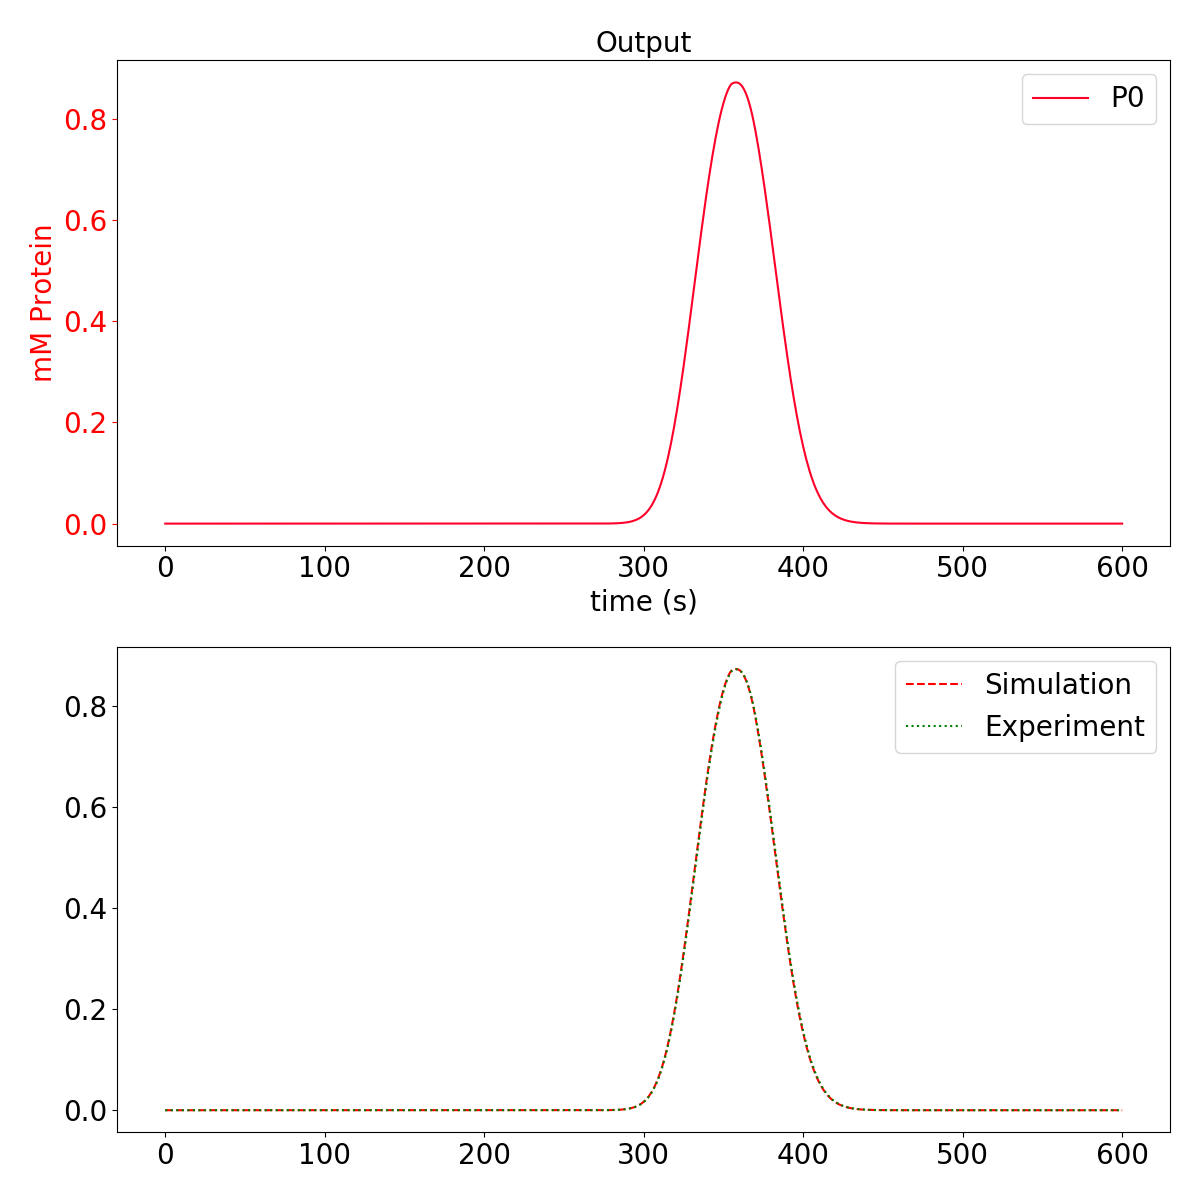

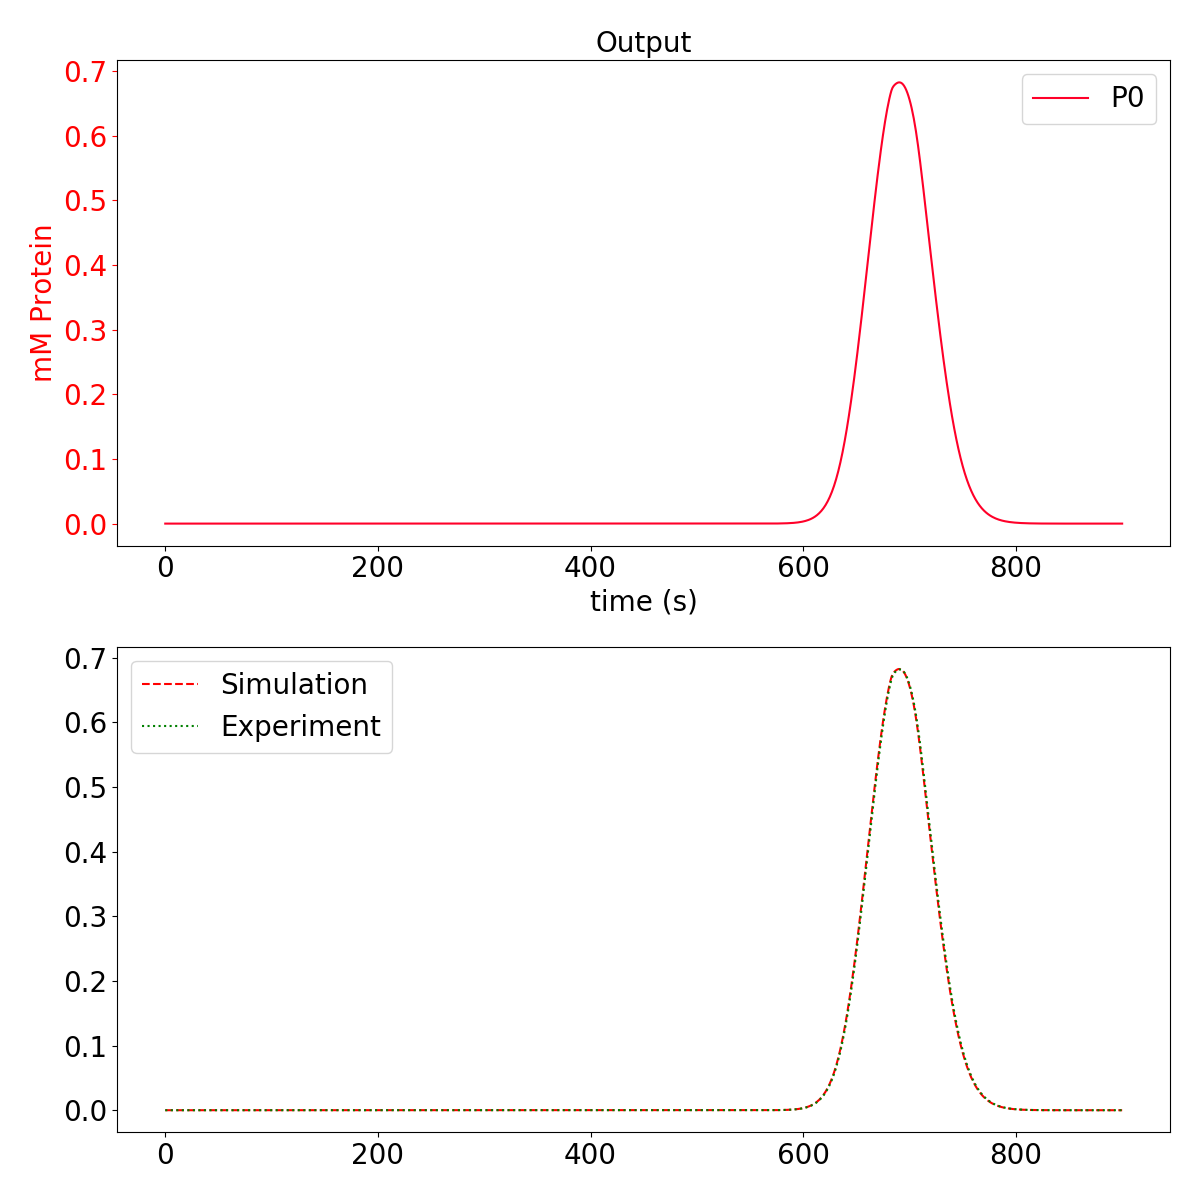

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.98e-07  true_value = 2.00e-07 error: 0.99%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 0.04%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 0.11%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 0.084%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 1.98e-07  true_value = 2.00e-07 error: 0.99%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 0.04%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 0.11%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 0.084%




In [11]:
true_values = numpy.array([simple.root.input.model.unit_001.col_dispersion, 
                           simple.root.input.model.unit_001.col_porosity])
    
sim_multiple = run_match(match_multiple,
                    match_file,
                    true_values,
                    delete=True)

# Multiple components
Dealing with multiple components is only slightly more complex. For this example I will take the Dextran pulse example and add a second component to it with a different concentration. After that we will look at how to fit the system with a score for each component.

CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_5/multiple_components/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


C:\Users\kosh_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


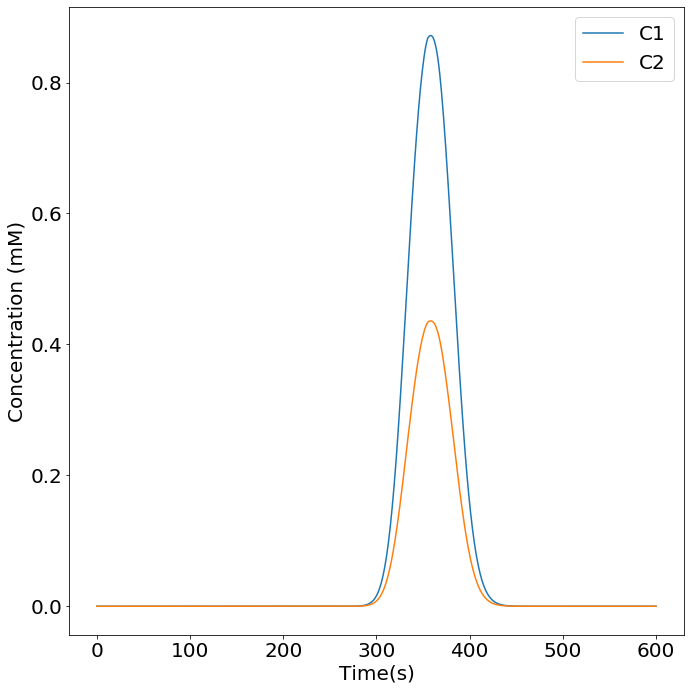

In [23]:
comps_dir = lesson_5 / "multiple_components"
comps_dir.mkdir(exist_ok = True)

simple = Cadet()

#give a filename for where the simulation should be saved
simple.filename = (lesson_1 / "simple_example" / 'example.h5').as_posix()

simple.load()

simple.filename = (comps_dir / 'example.h5').as_posix()

#add a second component, many small things change with this

simple.root.input.model.unit_000.ncomp = 2

#const_coeff + lin_coeff*t + quad_coeff*t^2 + cube_coeff*t^3
simple.root.input.model.unit_000.sec_000.const_coeff = [1.0, 0.5]
simple.root.input.model.unit_000.sec_000.lin_coeff =   [0.0, 0.0]
simple.root.input.model.unit_000.sec_000.quad_coeff =  [0.0, 0.0]
simple.root.input.model.unit_000.sec_000.cube_coeff =  [0.0, 0.0]

simple.root.input.model.unit_000.sec_001.const_coeff = [0.0, 0.0]
simple.root.input.model.unit_000.sec_001.lin_coeff =   [0.0, 0.0]
simple.root.input.model.unit_000.sec_001.quad_coeff =  [0.0, 0.0]
simple.root.input.model.unit_000.sec_001.cube_coeff =  [0.0, 0.0]

simple.root.input.model.unit_002.ncomp = 2

simple.root.input.model.unit_001.ncomp = 2
simple.root.input.model.unit_001.init_c = [0.0, 0.0]
simple.root.input.model.unit_001.init_q = [0.0, 0.0]
simple.root.input.model.unit_001.film_diffusion = [0.0, 0.0]

simple.root.input.model.unit_001.discretization.nbound = [0, 0]

#save the simulation
simple.save()

#run the simulation
data = simple.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    simple.load()
    
    times = simple.root.output.solution.solution_times
    values1 = simple.root.output.solution.unit_002.solution_outlet_comp_000
    values2 = simple.root.output.solution.unit_002.solution_outlet_comp_001
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(times, values1, label='C1')
    plt.plot(times, values2, label='C2')
    plt.legend()
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    plt.show()
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([times,
                        values1]).transpose()
    data.to_csv((comps_dir / 'example_c1.csv').as_posix(), index=False, header=False)
    
    data = pandas.DataFrame([times,
                        values2]).transpose()
    data.to_csv((comps_dir / 'example_c2.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Create a configuration file

In this case we are matching to a single experiment with two components but using the same two input variables.

In [13]:
match_comps = Dict(match.copy())
match_comps.CADETPath = cadet_path.as_posix()
match_comps.baseDir = comps_dir.as_posix()
match_comps.resultsDir = 'fit_nsga3_comps'


experiment1 = Dict()
experiment1.csv = "example_c1.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"
experiment1.timeout = 30.0

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'DextranShape'
feature1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
feature1.csv = "example_c1.csv"

feature2 = Dict()
feature2.name = "Pulse"
feature2.type = 'DextranShape'
feature2.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_001"
feature2.csv = "example_c2.csv"

experiment1.features = [feature1,]

match_comps.experiments = [experiment1,]

match_file = comps_dir / 'example_nsga3_multiple.json'

with (match_file).open('w') as json_file:
    json.dump(match_comps.to_dict(), json_file, indent='\t')

## Run parameter estimation

Your results are located at F:/temp/cadet_tutorial/lesson_5/multiple_components/fit_nsga3_comps 


[2019-10-02 10:32:05,704] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-02 10:32:05,704] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-02 10:32:05,704] launcher  INFO    Worker distribution: 

[2019-10-02 10:32:05,704] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-02 10:32:11,538] util      (b'127.0.0.1:58313') INFO    Generation: -1 	Population: 24 	Average Score: 0.931 	Best: 0.997 	Minimum Score: 0.863 	Best: 0.997 	Product Score: 0.924 	Best: 0.997

[2019-10-02 10:32:12,816] util      (b'127.0.0.1:58313') INFO    Generation: 0 	Population: 24 	Average Score: 0.946 	Best: 0.997 	Minimum Score: 0.893 	Best: 0.997 	Product Score: 0.942 	Best: 0.997

[2019-10-02 10:32:14,128] util      (b'127.0.0.1:58313') INFO    Generation: 1 	Populatio

[2019-10-02 10:32:58,876] util      (b'127.0.0.1:58313') INFO    Generation: 40 	Population: 24 	Average Score: 1 	Best: 1 	Minimum Score: 1 	Best: 1 	Product Score: 1 	Best: 1

[2019-10-02 10:32:59,945] util      (b'127.0.0.1:58313') INFO    Generation: 41 	Population: 24 	Average Score: 1 	Best: 1 	Minimum Score: 1 	Best: 1 	Product Score: 1 	Best: 1

[2019-10-02 10:33:01,122] util      (b'127.0.0.1:58313') INFO    Generation: 42 	Population: 24 	Average Score: 1 	Best: 1 	Minimum Score: 1 	Best: 1 	Product Score: 1 	Best: 1

[2019-10-02 10:33:02,270] util      (b'127.0.0.1:58313') INFO    Generation: 43 	Population: 24 	Average Score: 1 	Best: 1 	Minimum Score: 1 	Best: 1 	Product Score: 1 	Best: 1

[2019-10-02 10:33:03,437] util      (b'127.0.0.1:58313') INFO    Generation: 44 	Population: 24 	Average Score: 1 	Best: 1 	Minimum Score: 1 	Best: 1 	Product Score: 1 	Best: 1

[2019-10-02 10:33:04,612] util      (b'127.0.0.1:58313') INFO    Generation: 45 	Population: 24 	Average Score

,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_Shape,main_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
0,Wed Oct 2 10:33:09 2019,bdfc8c2fdd14c47a2a9ca46343453721,GRAD,NaN,1.999522e-07,0.369996,1.0,1.0,1.0,1.0,1.0,9.595814e-12


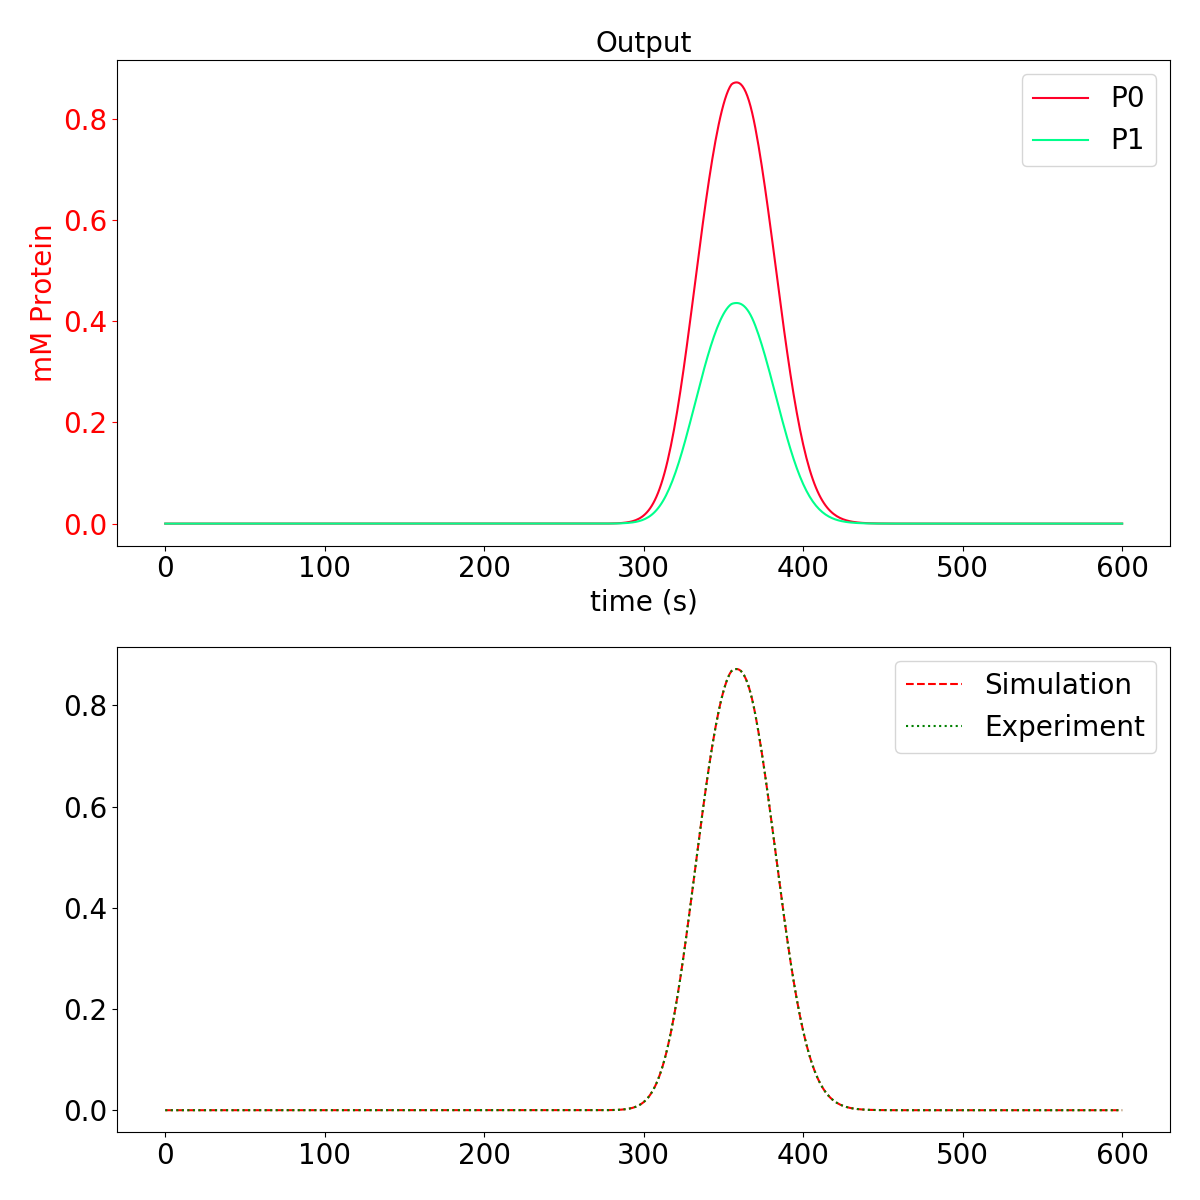

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 0.024%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 0.0011%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 0.024%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 0.0011%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 0.024%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 0.0011%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 0.024%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 0.0011%




In [14]:
true_values = numpy.array([simple.root.input.model.unit_001.col_dispersion, 
                           simple.root.input.model.unit_001.col_porosity])
    
sim_comps = run_match(match_comps,
                    match_file,
                    true_values,
                    delete=True)

# Fractionation

Fractionation is when you collect a series of samples from the outlet and measure the concentration of each component. Usually there are 5-10 samples avaiable and a summation UV signal. These are some of the most complex systems to fit.

We will fractionate the multiple components example and fit to the summation UV signal and fractionation data.

The first step is to take our existing multiple component simulation that we just used to create a sum signal and fractionation data. No changes will be made to the simulation, we just need to read the data again.

The fraction graph generated uses lines to join points but they are not actualy continuous. Based on experience these graphs are much harder to follow with the eye if you don't have lines connecting the data points.

No handles with labels found to put in legend.
C:\Users\kosh_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
C:\Users\kosh_000\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


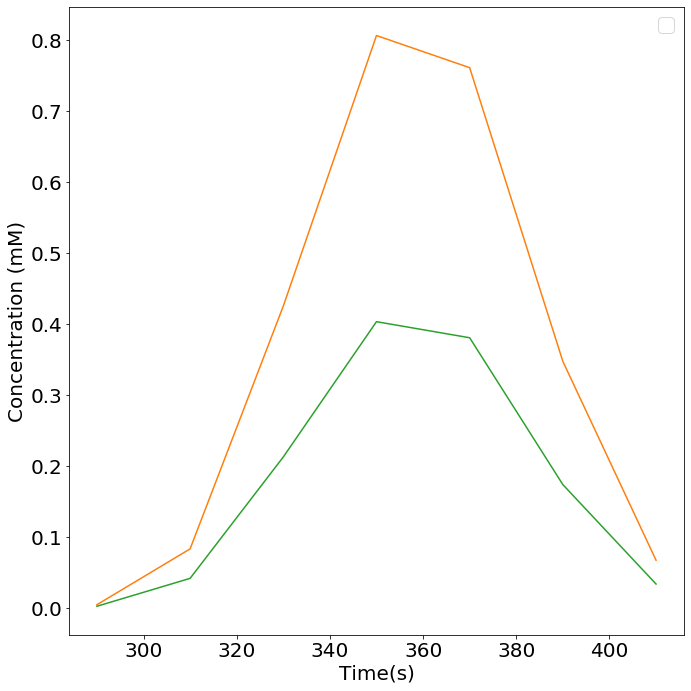

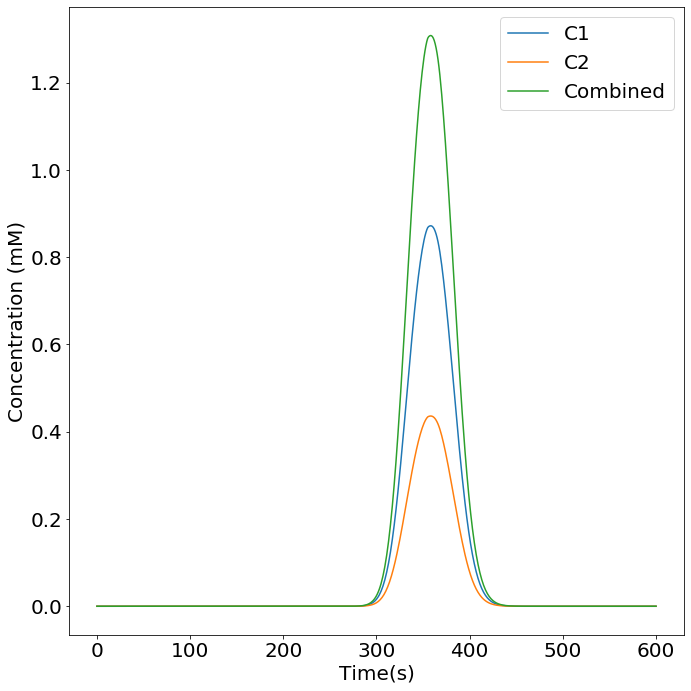

In [24]:
simple = Cadet()

simple.filename = (comps_dir / 'example.h5').as_posix()

simple.load()


times = simple.root.output.solution.solution_times
values1 = simple.root.output.solution.unit_002.solution_outlet_comp_000
values2 = simple.root.output.solution.unit_002.solution_outlet_comp_001

start_seq = [280, 300, 320, 340, 360, 380, 400]
stop_seq = [300, 320, 340, 360, 380, 400, 420]

min_seq = (numpy.array(start_seq) + numpy.array(stop_seq))/2.0


frac1 = fractionate(start_seq, stop_seq, times, values1)
frac2 = fractionate(start_seq, stop_seq, times, values2)

plt.figure(figsize=[10,10])
plt.plot(min_seq, frac1, 'C1')
plt.plot(min_seq, frac2, 'C2')
plt.legend()
plt.show()
plt.xlabel('Time(s)')
plt.ylabel('Concentration (mM)')

df = pandas.DataFrame.from_dict({'Start':start_seq, 'Stop':stop_seq, '0':frac1, '1':frac2})
df.to_csv((comps_dir / 'example_fractions.csv').as_posix(), columns=('Start', 'Stop', '0', '1'), index=False)


#plot the simulation
plt.figure(figsize=[10,10])
plt.plot(times, values1, label='C1')
plt.plot(times, values2, label='C2')
plt.plot(times, values1 + values2, label='Combined')
plt.legend()
plt.show()
plt.xlabel('Time(s)')
plt.ylabel('Concentration (mM)')

#write the chromatogram data out to a csv file
data = pandas.DataFrame([times,
                    values1+values2]).transpose()
data.to_csv((comps_dir / 'example_combined.csv').as_posix(), index=False, header=False)

## Create a configuration file
There are only a few changes that need to be made to the file to deal with fractionation.

Since we are dealing with the sum signal we need to compare that with the sum of components in our simulation. With CADETMatch you can make isotherm a list and the software will add up all the values in the list. In this case we are adding up component 0 and component 1 with

```python
feature1.isotherm = ["/output/solution/unit_002/SOLUTION_OUTLET_COMP_000", "/output/solution/unit_002/SOLUTION_OUTLET_COMP_001"]
```

The next thing is to create a fractionation setup which looks like

```python
feature = Dict()
feature.name = "Frac"
feature.type = 'fractionationSlide'
feature.fraction_csv = "example_fractions.csv"
feature.unit_name = 'unit_002'
```

or in json it looks like

```json
{
    "name": "Frac",
    "type": 'fractionationSlide',
    "fraction_csv": "example_fractions.csv",
    "unit_name": 'unit_002'
}
```

fraction_csv needs to be the path to the csv file that has fractionation data
unit_name needs to be the name of the unit operation we are trying to fractionate in the system.

In [16]:
match_frac = Dict(match.copy())
match_frac.CADETPath = cadet_path.as_posix()
match_frac.baseDir = comps_dir.as_posix()
match_frac.resultsDir = 'fit_nsga3_frac'

experiment1 = Dict()
experiment1.csv = "example_c1.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"
experiment1.timeout = 30.0

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'Shape'
feature1.isotherm = ["/output/solution/unit_002/SOLUTION_OUTLET_COMP_000", "/output/solution/unit_002/SOLUTION_OUTLET_COMP_001"]
feature1.csv = "example_combined.csv"

feature2 = Dict()
feature2.name = "Frac"
feature2.type = 'fractionationSlide'
feature2.fraction_csv = "example_fractions.csv"
feature2.unit_name = 'unit_002'

experiment1.features = [feature1, feature2]

match_frac.experiments = [experiment1,]

match_file = comps_dir / 'example_nsga3_fractionation.json'

with (match_file).open('w') as json_file:
    json.dump(match_frac.to_dict(), json_file, indent='\t')

## Run parameter estimation
Fractionation is a hard problem and it can take significantly longer to fit than if full chromatograms are available. There is less data available and so it is harder to tell if an answer is better or worse.

Your results are located at F:/temp/cadet_tutorial/lesson_5/multiple_components/fit_nsga3_frac 


[2019-10-02 10:33:37,407] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-02 10:33:37,407] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-02 10:33:37,407] launcher  INFO    Worker distribution: 

[2019-10-02 10:33:37,407] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-02 10:33:44,296] util      (b'127.0.0.1:56481') INFO    Generation: -1 	Population: 24 	Average Score: 0.949 	Best: 0.959 	Minimum Score: 0.851 	Best: 0.893 	Product Score: 0.947 	Best: 0.957

[2019-10-02 10:33:46,193] util      (b'127.0.0.1:56481') INFO    Generation: 0 	Population: 24 	Average Score: 0.946 	Best: 0.959 	Minimum Score: 0.842 	Best: 0.893 	Product Score: 0.945 	Best: 0.957

[2019-10-02 10:33:48,276] util      (b'127.0.0.1:56481') INFO    Generation: 1 	Population

,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,COL_POROSITY Comp:-1 Bound:-1,main_Pulse_Similarity,main_Pulse_Value,main_Pulse_Time,main_Pulse_Derivative_Similarity,...,main_Frac_Component_0_Similarity,main_Frac_Component_0_Time,main_Frac_Component_0_Value,main_Frac_Component_1_Similarity,main_Frac_Component_1_Time,main_Frac_Component_1_Value,Product Root Score,Min Score,Mean Score,SSE
0,Wed Oct 2 10:34:53 2019,62baaaf44605c4d658d39ce681cdaec5,GRAD,NaN,2.000000e-07,0.37,1.0,1.0,0.999996,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.999996,1.0,7.973248e-19


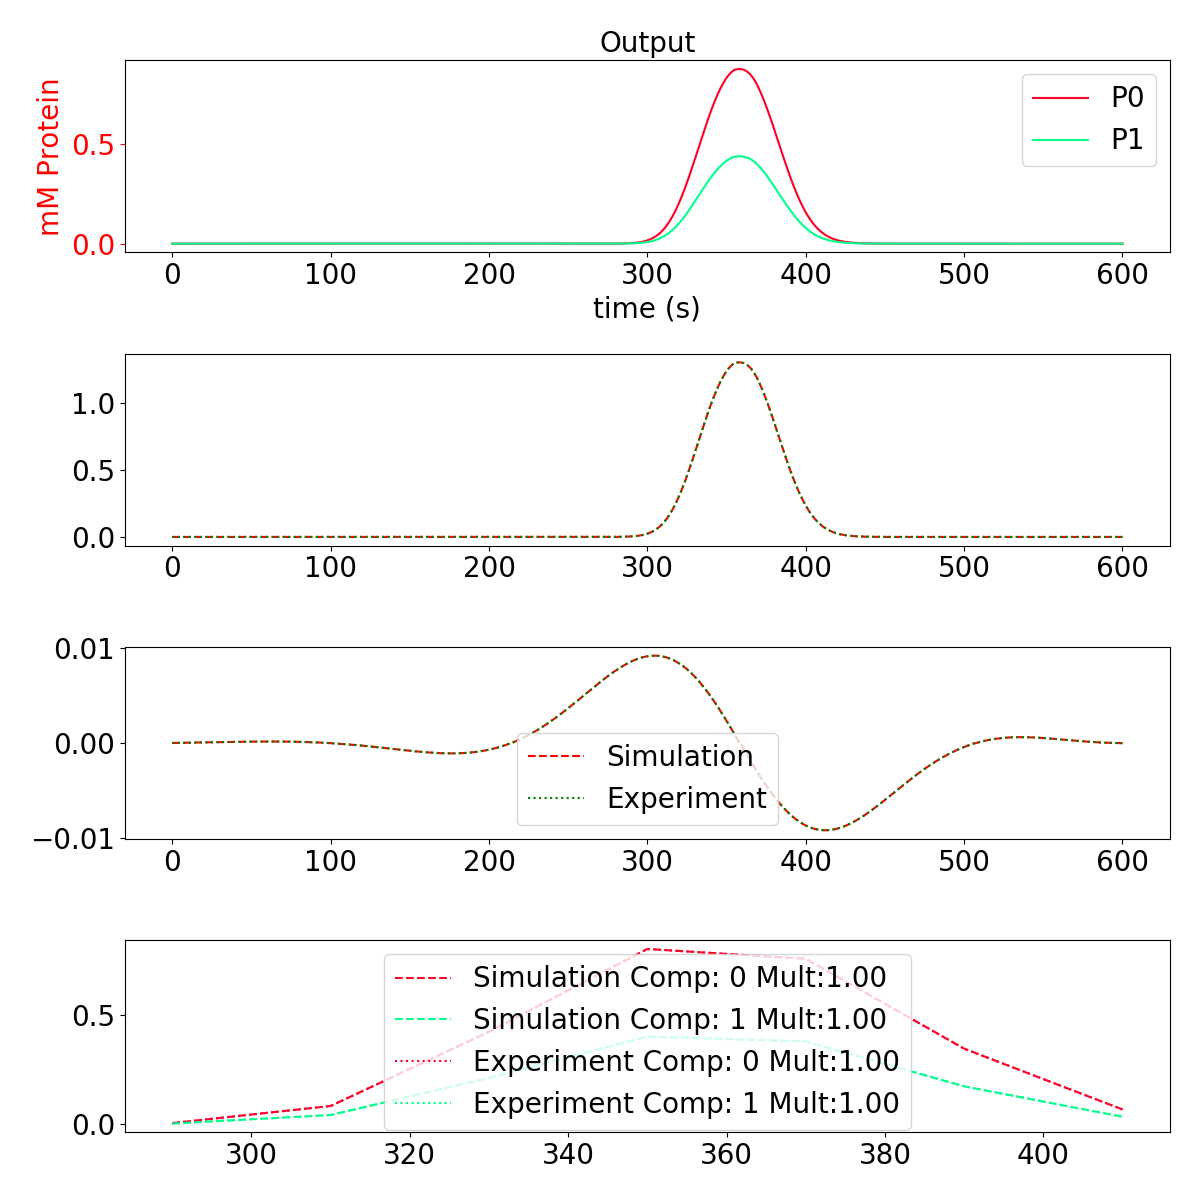

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 4.8e-08%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 7.5e-11%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 4.8e-08%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 7.5e-11%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 4.8e-08%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 7.5e-11%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 2.00e-07  true_value = 2.00e-07 error: 4.8e-08%
COL_POROSITY Comp:-1 Bound:-1 = 3.70e-01  true_value = 3.70e-01 error: 7.5e-11%




In [17]:
true_values = numpy.array([simple.root.input.model.unit_001.col_dispersion, 
                           simple.root.input.model.unit_001.col_porosity])
    
sim_frac = run_match(match_frac,
                    match_file,
                    true_values,
                    delete=True)

# Estimating per component parameters
One of the final steps is estimating parameters that are different for each component. For this test we will take the 2-component SMA example from Lesson 3 and estimate nu for each component. In practice you can estimate any number of variables although as you estimate more variables you also need more data and more computation time which rises very rapidly. 

## Copy the simulation from Lesson 3 and make sure it runs correctly

CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_5/multiple_parameters/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


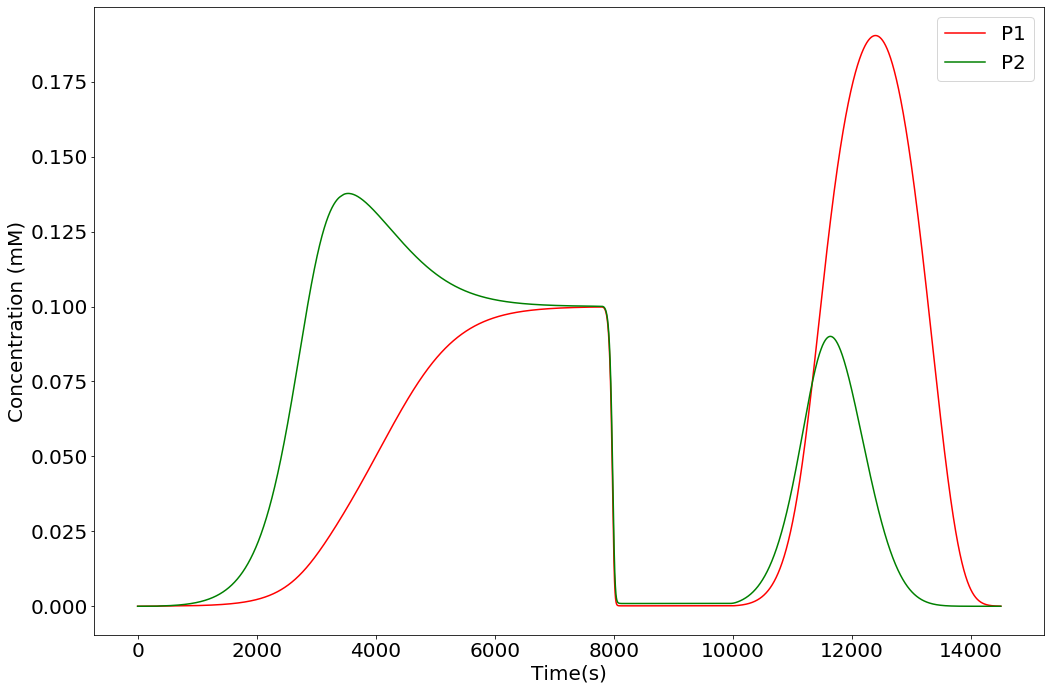

In [7]:
multiple_parameters = lesson_5 / "multiple_parameters"
multiple_parameters.mkdir(exist_ok = True)

multi = Cadet()

#give a filename for where the simulation should be saved
multi.filename = (lesson_3 / "sma2_example" / 'example.h5').as_posix()

multi.load()

multi.filename = (multiple_parameters / 'example.h5').as_posix()

#save the simulation
multi.save()

#run the simulation
data = multi.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    multi.load()
    
    #plot the simulation
    plt.figure(figsize=[15,10])
    plt.plot(multi.root.output.solution.solution_times,
        multi.root.output.solution.unit_002.solution_outlet_comp_001, 'r', label="P1")
    plt.plot(multi.root.output.solution.solution_times,
        multi.root.output.solution.unit_002.solution_outlet_comp_002, 'g', label="P2")
    plt.legend()
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([multi.root.output.solution.solution_times,
                        multi.root.output.solution.unit_002.solution_outlet_comp_001]).transpose()
    data.to_csv((multiple_parameters / 'example_c1.csv').as_posix(), index=False, header=False)
    
    data = pandas.DataFrame([multi.root.output.solution.solution_times,
                        multi.root.output.solution.unit_002.solution_outlet_comp_002]).transpose()
    data.to_csv((multiple_parameters / 'example_c2.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Create configuration file
Now that we are estimating parameters that are per component we need to make a couple simple changes to the parameters field.

The component field is the component number we need to change. In this case 0 is salt, 1 is protein 1 and 2 is protein 2. We want to estimate NU for protein 1 and 2. 

The bound field should be set to 0 since we want the first bound state. Some isotherms have multiple bound states.

```python
parameter = Dict()
parameter.transform = 'norm'
parameter.component = 1
parameter.bound = 0
parameter.location = "/input/model/unit_001/adsorption/SMA_NU"
parameter.min = 2
parameter.max = 15
```

In JSON it looks like

```json
{
    'transform': 'norm',
    'component': 1,
    'bound': 0,
    'location': "/input/model/unit_001/adsorption/SMA_NU",
    'min': 2,
    'max':15
}
```

In [8]:
match = Dict()
match.CADETPath = cadet_path.as_posix()
match.baseDir = multiple_parameters.as_posix()
match.resultsDir = 'fit_nsga3'
match.csv = 'fit_results.csv'
match.checkpointFile = "check"
match.stopAverage = 1
match.stopBest = 1
match.gradCheck = 1
match.gradVector = 1
match.searchMethod = 'NSGA3'
match.mutationRate = 1.0
match.crossoverRate = 1.0
match.generations = 1000
match.population = 12
match.minPopulation = 12
match.maxPopulation = 12
match.finalGradRefinement = 1
match.stallGenerations = 10

parameter1 = Dict()
parameter1.transform = 'norm'
parameter1.component = 1
parameter1.bound = 0
parameter1.location = "/input/model/unit_001/adsorption/SMA_NU"
parameter1.min = 2
parameter1.max = 15

parameter2 = Dict()
parameter2.transform = 'norm'
parameter2.component = 2
parameter2.bound = 0
parameter2.location = "/input/model/unit_001/adsorption/SMA_NU"
parameter2.min = 2
parameter2.max = 15

match.parameters = [parameter1, parameter2]

experiment1 = Dict()
experiment1.csv = "example_c1.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "example.h5"
experiment1.name = "main"
experiment1.timeout = 30.0

feature1 = Dict()
feature1.name = "C1"
feature1.type = 'Shape'
feature1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_001"
feature1.csv = "example_c1.csv"

feature2 = Dict()
feature2.name = "C2"
feature2.type = 'Shape'
feature2.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_002"
feature2.csv = "example_c2.csv"

experiment1.features = [feature1, feature2]

match.experiments = [experiment1,]

match_file = multiple_parameters / 'example_nsga3.json'

with (match_file).open('w') as json_file:
    json.dump(match.to_dict(), json_file, indent='\t')

## Run parameter estimation

Your results are located at F:/temp/cadet_tutorial/lesson_5/multiple_parameters/fit_nsga3 


[2019-10-10 16:47:16,802] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-10 16:47:16,802] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-10 16:47:16,802] launcher  INFO    Worker distribution: 

[2019-10-10 16:47:16,802] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-10 16:47:20,436] util      (b'127.0.0.1:52650') INFO    example.h5 abstol=1.38e-05  reltol=0.0001

[2019-10-10 16:47:22,739] match     (b'127.0.0.1:52650') INFO    simulation took 2.302661418914795

[2019-10-10 16:47:37,871] gradFD    (b'127.0.0.1:52650') INFO    grad simulation took 15.081256628036499

[2019-10-10 16:47:37,871] gradFD    (b'127.0.0.1:52650') INFO    grad F:/temp/cadet_tutorial/lesson_5/multiple_parameters/fit_nsga3/misc/template_main_grad.h5 abstol=1.38e-11  reltol=1

[2019-10-10 17:04:19,447] launcher  (127.0.0.1:61469) INFO    Root process is done.

[2019-10-10 17:04:19,448] launcher  (127.0.0.1:61469) INFO    Finished cleaning spawned subprocesses.

Best item 62c5945415d1d1f73b0455fa4d4f95a5 for meta score(s) Product Root Score , Min Score , Mean Score , SSE


,Time,Name,Method,Condition Number,SMA_NU Comp:1 Bound:0,SMA_NU Comp:2 Bound:0,main_C1_Similarity,main_C1_Value,main_C1_Time,main_C1_Derivative_Similarity,...,main_C2_Similarity,main_C2_Value,main_C2_Time,main_C2_Derivative_Similarity,main_C2_Der_High_Value,main_C2_Der_Low_Value,Product Root Score,Min Score,Mean Score,SSE
0,Thu Oct 10 17:03:27 2019,62c5945415d1d1f73b0455fa4d4f95a5,GRAD,NaN,6.999992,4.999983,0.999998,0.999942,0.999188,0.999865,...,0.999997,0.999564,0.998836,0.999941,0.998079,0.999747,0.99948,0.998079,0.999481,0.000013


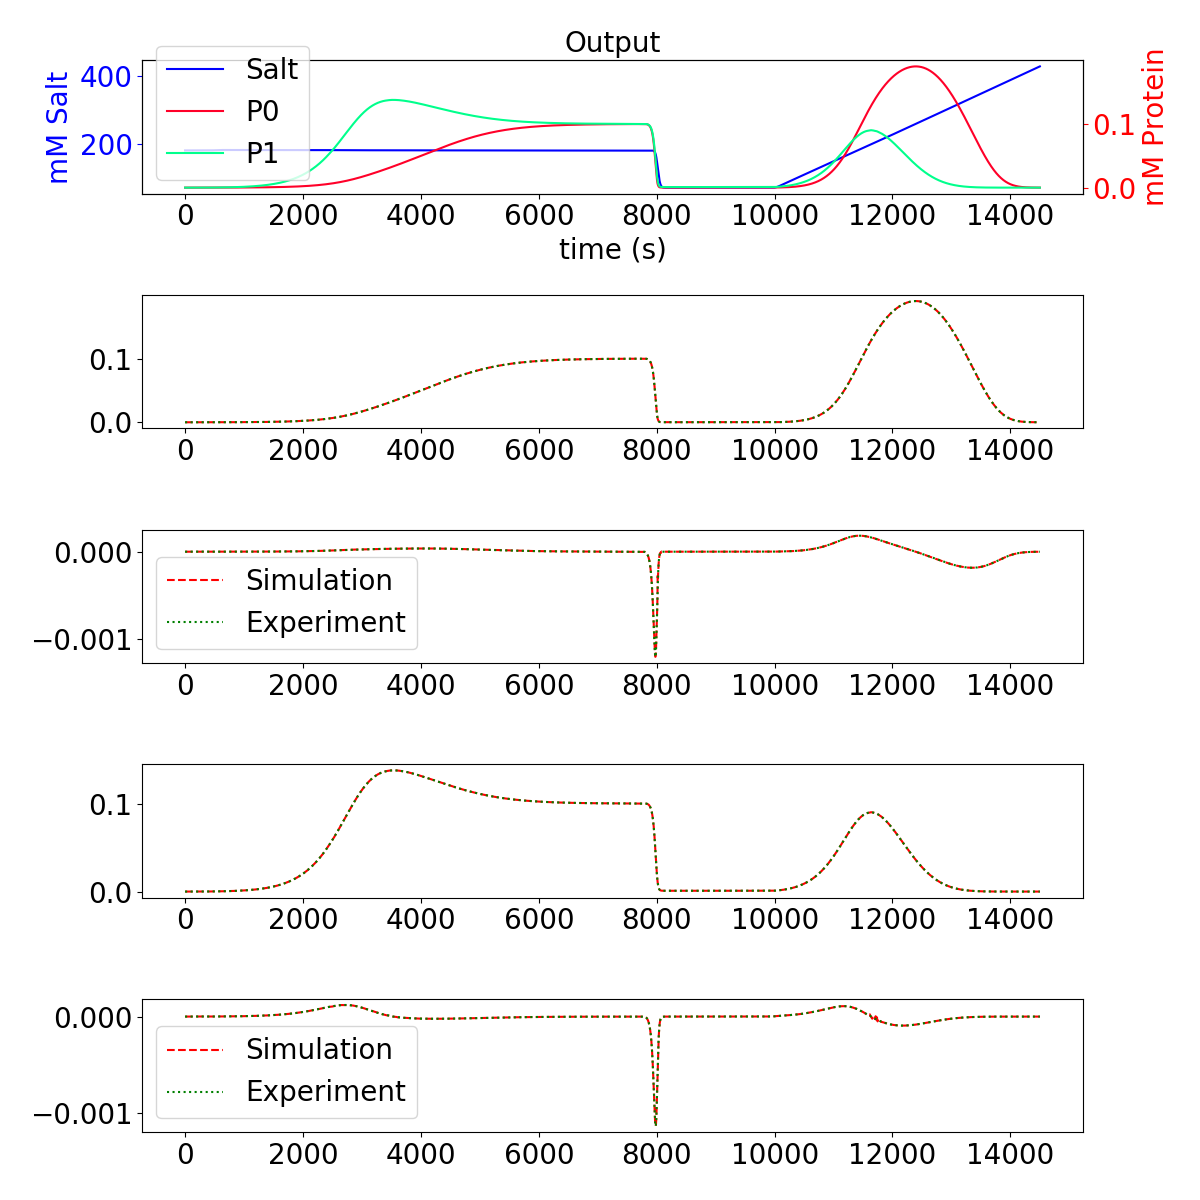

Method: Product Root Score
SMA_NU Comp:1 Bound:0 = 7.00e+00  true_value = 7.00e+00 error: 0.00012%
SMA_NU Comp:2 Bound:0 = 5.00e+00  true_value = 5.00e+00 error: 0.00034%


Method: Min Score
SMA_NU Comp:1 Bound:0 = 7.00e+00  true_value = 7.00e+00 error: 0.00012%
SMA_NU Comp:2 Bound:0 = 5.00e+00  true_value = 5.00e+00 error: 0.00034%


Method: Mean Score
SMA_NU Comp:1 Bound:0 = 7.00e+00  true_value = 7.00e+00 error: 0.00012%
SMA_NU Comp:2 Bound:0 = 5.00e+00  true_value = 5.00e+00 error: 0.00034%


Method: SSE
SMA_NU Comp:1 Bound:0 = 7.00e+00  true_value = 7.00e+00 error: 0.00012%
SMA_NU Comp:2 Bound:0 = 5.00e+00  true_value = 5.00e+00 error: 0.00034%




In [9]:
true_values = numpy.array([multi.root.input.model.unit_001.adsorption.sma_nu[1], 
                           multi.root.input.model.unit_001.adsorption.sma_nu[2]])
    
sim_parm = run_match(match,
                    match_file,
                    true_values,
                    delete=True)